In [101]:
#imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score


In [64]:
print("Starting project...")
print("Hello, world!")

Starting project...
Hello, world!


In [77]:
data = pd.read_csv("Crimes - 2001 to present (25th mai 2020).csv", dtype=object)

In [66]:
data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11034701,JA366925,01/01/2001 11:00:00 AM,016XX E 86TH PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,false,false,...,8,45,11,NaN,NaN,2001,08/05/2017 03:50:08 PM,NaN,NaN,NaN
1,11227287,JB147188,10/08/2017 03:00:00 AM,092XX S RACINE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,false,false,...,21,73,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
2,11227583,JB147595,03/28/2017 02:00:00 PM,026XX W 79TH ST,0620,BURGLARY,UNLAWFUL ENTRY,OTHER,false,false,...,18,70,05,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
3,11227293,JB147230,09/09/2017 08:17:00 PM,060XX S EBERHART AVE,0810,THEFT,OVER $500,RESIDENCE,false,false,...,20,42,06,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN
4,11227634,JB147599,08/26/2017 10:00:00 AM,001XX W RANDOLPH ST,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOTEL/MOTEL,false,false,...,42,32,02,NaN,NaN,2017,02/11/2018 03:57:41 PM,NaN,NaN,NaN


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899981 entries, 0 to 4899980
Data columns (total 22 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   ID                    object
 1   Case Number           object
 2   Date                  object
 3   Block                 object
 4   IUCR                  object
 5   Primary Type          object
 6   Description           object
 7   Location Description  object
 8   Arrest                object
 9   Domestic              object
 10  Beat                  object
 11  District              object
 12  Ward                  object
 13  Community Area        object
 14  FBI Code              object
 15  X Coordinate          object
 16  Y Coordinate          object
 17  Year                  object
 18  Updated On            object
 19  Latitude              object
 20  Longitude             object
 21  Location              object
dtypes: object(22)
memory usage: 822.4+ MB


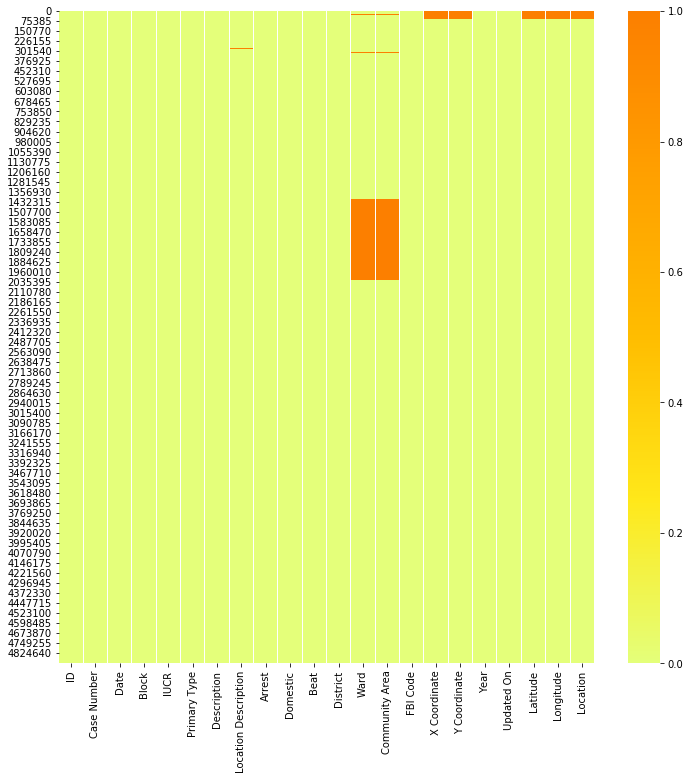

In [7]:
# Visualize how many values are null before engineering
# plt.figure(figsize=(12, 12))
# sns.heatmap(data.isnull(), cbar=True, cmap='Wistia')

In [78]:
# since the dataset is absolutely immense, we can easily drop the NaN rows
data = data.dropna()

data['Year'] = pd.to_numeric(data['Year']) 
# We've eliminated 2020 to minimize the risk of possible anomalies happening in 2020 due to Covid-19
data = data[(data.Year > 2000) & (data.Year < 2020)] 

data = data.sample(n=100000)


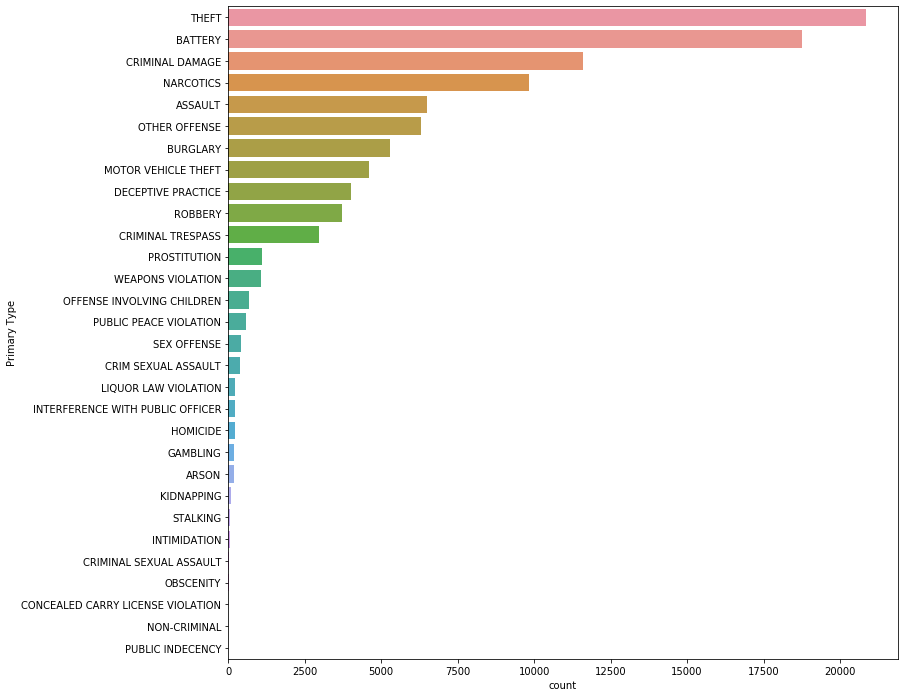

In [79]:
# types of crimes
plt.figure(figsize=(12, 12))
sns.countplot(y="Primary Type", data=data, order=data['Primary Type'].value_counts().iloc[:].index)

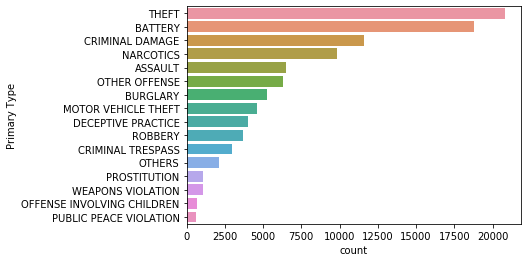

In [80]:
# First, we sum up the amount of Crime Type happened and select the last 13 classes
all_classes = data.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

unwanted_classes = all_classes.tail(15)
unwanted_classes
# After that, we replaced it with label 'OTHERS'
data.loc[data['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'
sns.countplot(y="Primary Type", data=data, order=data['Primary Type'].value_counts().iloc[:].index)

In [81]:
# Feature engineering
# 1. Drop unused tables: ID, Case Number
data = data.drop(['ID', 'X Coordinate', 'Y Coordinate', 'Block', 'Updated On', 'Location', 'Description', 'Location Description'], axis=1)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 2123900 to 2680996
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Case Number     100000 non-null  object
 1   Date            100000 non-null  object
 2   IUCR            100000 non-null  object
 3   Primary Type    100000 non-null  object
 4   Arrest          100000 non-null  object
 5   Domestic        100000 non-null  object
 6   Beat            100000 non-null  object
 7   District        100000 non-null  object
 8   Ward            100000 non-null  object
 9   Community Area  100000 non-null  object
 10  FBI Code        100000 non-null  object
 11  Year            100000 non-null  int64 
 12  Latitude        100000 non-null  object
 13  Longitude       100000 non-null  object
dtypes: int64(1), object(13)
memory usage: 13.9+ MB


In [22]:
data.Date

4384556    06/12/2007 10:00:00 PM
3944929    06/14/2006 07:30:00 PM
3566157    08/04/2005 02:00:00 PM
96622      06/30/2019 10:41:00 PM
2969137    04/24/2004 08:44:01 AM
                    ...          
4169555    12/17/2006 10:00:00 AM
2962423    04/20/2004 12:00:00 AM
3797339    02/13/2006 12:10:00 AM
1119519    03/22/2018 08:00:00 PM
1318913    12/20/2018 04:00:00 PM
Name: Date, Length: 100000, dtype: object

In [82]:
# Since we loaded the model with object as dtype (for faster loading), 
# we're going to specify all the types manually
data['DateTime'] = pd.to_datetime(data['Date'])
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['Day'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour

data = data.drop(['Date'], axis=1)
data = data.drop(['DateTime'], axis=1)

In [83]:
# Convert categorical attributes to Numerical
data['Case Number'] = pd.factorize(data['Case Number'])[0]
data['IUCR'] = pd.factorize(data['IUCR'])[0]
data['Primary Type'] = pd.factorize(data['Primary Type'])[0]
data['Arrest'] = pd.factorize(data['Arrest'])[0]
data['Domestic'] = pd.factorize(data['Domestic'])[0]
data['Beat'] = pd.factorize(data['Beat'])[0]
data['District'] = pd.factorize(data['District'])[0]
data['Ward'] = pd.factorize(data['Ward'])[0]
data['Community Area'] = pd.factorize(data['Community Area'])[0]
data['FBI Code'] = pd.factorize(data['FBI Code'])[0]
data['Latitude'] = pd.factorize(data['Latitude'])[0]
data['Longitude'] = pd.factorize(data['Longitude'])[0]

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 2123900 to 2680996
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Case Number     100000 non-null  int64
 1   IUCR            100000 non-null  int64
 2   Primary Type    100000 non-null  int64
 3   Arrest          100000 non-null  int64
 4   Domestic        100000 non-null  int64
 5   Beat            100000 non-null  int64
 6   District        100000 non-null  int64
 7   Ward            100000 non-null  int64
 8   Community Area  100000 non-null  int64
 9   FBI Code        100000 non-null  int64
 10  Year            100000 non-null  int64
 11  Latitude        100000 non-null  int64
 12  Longitude       100000 non-null  int64
 13  Month           100000 non-null  int64
 14  Day             100000 non-null  int64
 15  Hour            100000 non-null  int64
dtypes: int64(16)
memory usage: 15.5 MB


In [85]:
data['Primary Type'].value_counts()

3     20844
5     18763
1     11609
10     9822
7      6506
8      6306
9      5291
6      4618
2      4028
0      3712
11     2964
12     2116
15     1093
4      1063
13      675
14      590
Name: Primary Type, dtype: int64

Text(0, 0.5, '# of Crimes')

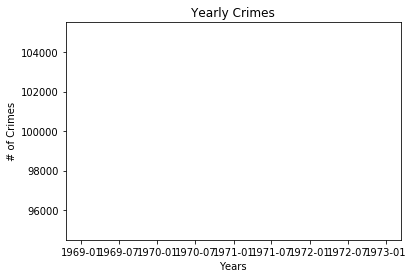

In [87]:
data.index = pd.to_datetime(data.index, unit='s')
plt.plot(data.resample('Y').size())
plt.title('Yearly Crimes')
plt.xlabel('Years')
plt.ylabel('# of Crimes')

In [88]:
data['Primary Type'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [89]:
X = data.drop(['Primary Type'], axis = 1)
y = data['Primary Type']
y = pd.factorize(y)[0]

In [90]:
# spliting data into training: 50%, validation: 25% and testing: 25%
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.5, train_size = 0.5, random_state = 42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size = 0.5, train_size = 0.5, random_state = 42)



In [91]:
# Number of entries in train, test and validation sets
print('Training data:', len(X_train))
print('Testing data:',len(X_test))
print('Validation data:',len(X_validation))

Training data: 50000
Testing data: 25000
Validation data: 25000


In [98]:
neighborsScore = []
max_score = 0
max_k = 0
for k in range(150, 300):# K-NN
    knn = KNeighborsClassifier(n_neighbors = k, metric='euclidean')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_validation)
    score = knn.score(X_validation, y_validation)
    if (score > max_score):
        max_score = score
        max_k = k
    print("Neighbors:", k, "Score:", score)
    neighborsScore.append(score)

print (neighborsScore)
print("Neighbors:", max_k, "Max Score:", max_score)
plt.plot(neighborsScore)

Neighbors: 150 Score: 0.204
Neighbors: 151 Score: 0.20368
Neighbors: 152 Score: 0.20332
Neighbors: 153 Score: 0.2032
Neighbors: 154 Score: 0.20248
Neighbors: 155 Score: 0.20292
Neighbors: 156 Score: 0.20248
Neighbors: 157 Score: 0.20292
Neighbors: 158 Score: 0.2026
Neighbors: 159 Score: 0.202
Neighbors: 160 Score: 0.20124
Neighbors: 161 Score: 0.20056
Neighbors: 162 Score: 0.20132
Neighbors: 163 Score: 0.20152
Neighbors: 164 Score: 0.20224
Neighbors: 165 Score: 0.20256
Neighbors: 166 Score: 0.20328
Neighbors: 167 Score: 0.20292
Neighbors: 168 Score: 0.20316
Neighbors: 169 Score: 0.20368
Neighbors: 170 Score: 0.2032
Neighbors: 171 Score: 0.20352
Neighbors: 172 Score: 0.20352
Neighbors: 173 Score: 0.20336
Neighbors: 174 Score: 0.2026
Neighbors: 175 Score: 0.20368
Neighbors: 176 Score: 0.20312
Neighbors: 177 Score: 0.2032
Neighbors: 178 Score: 0.20248
Neighbors: 179 Score: 0.20312
Neighbors: 180 Score: 0.20308
Neighbors: 181 Score: 0.20308
Neighbors: 182 Score: 0.2042
Neighbors: 183 Score

KeyboardInterrupt: 

In [97]:
# Random Forest
# Create Model with configuration
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X_train, y_train)

# Prediction
result = rf_model.predict(X_test)
ac_sc = accuracy_score(y_test, result)
print(ac_sc)

0.93896


In [100]:
# Prediction
result = rf_model.predict(X_validation)
ac_sc = accuracy_score(y_validation, result)
print(ac_sc)

0.93864


In [ ]:
# SVM
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

In [ ]:
predict = clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, predict)
# plot_confusion_matrix(cm,class_names)
cm

In [ ]:
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

#